# Segmenting nerves

In [45]:
import numpy as np
from skimage import io
im = io.imread('nerves_part.tiff').astype(np.float32)
print(im.shape)
import matplotlib.pyplot as plt

(1024, 350, 350)


In [48]:
img = im[0]

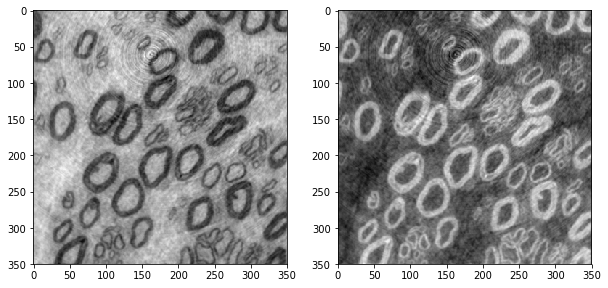

In [140]:
from skimage.util import invert

f, ax = plt.subplots(ncols=2, figsize=(10,6))

ax[0].imshow(img, cmap='gray')

inv = invert(img/255)
ax[1].imshow(inv, cmap='gray');

In [143]:
import cv2

hough = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1.2, 30)

error: OpenCV(4.0.0) /home/louis/opencv/modules/imgproc/src/hough.cpp:1736: error: (-215:Assertion failed) !_image.empty() && _image.type() == CV_8UC1 && (_image.isMat() || _image.isUMat()) in function 'HoughCircles'


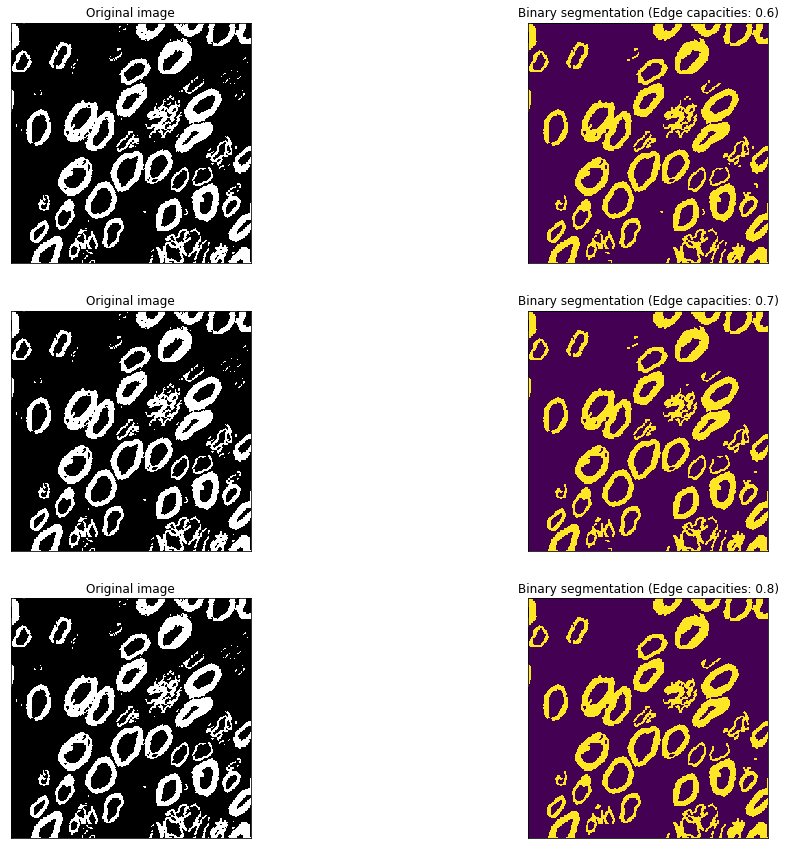

In [141]:
import scipy
import maxflow

inv = img<90

# Create the graph.
g = maxflow.Graph[float]()

# make each pixel of the image a (consecutively labeled) node
nodes = g.add_grid_nodes(inv.shape)



f, ax = plt.subplots(figsize = (17,15), nrows=3, ncols=2)

for index, i in enumerate(range(6,9)):
    
    # Add non-terminal edges with the same capacity as the nodes
    g.add_grid_edges(nodes, i/10)
    # Add the terminal edges. The image pixels are the capacities
    # of the edges from the source node. The inverted image pixels
    # are the capacities of the edges to the sink node.
    g.add_grid_tedges(nodes, inv, 1.2-inv)

    # Compute maximum flow.
    g.maxflow()
    
    # Get the segments of the nodes in the grid.
    # Their labels are 1 where sgm is False and 0 otherwise.
    sgm = g.get_grid_segments(nodes)
    
    # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    kernel = np.ones((5, 5), np.uint8)
    
    binaryimg = np.int_(np.logical_not(sgm))
    
    ax[index][0].imshow(inv, cmap='gray');
    ax[index][0].set(title='Original image', xticks=[], yticks=[])
    ax[index][1].imshow(np.int_(np.logical_not(sgm)));
    ax[index][1].set(title=('Binary segmentation (Edge capacities: '+ str(i/10)+')'), 
                            xticks=[], yticks=[])

In [133]:
from scipy.ndimage.morphology import binary_opening

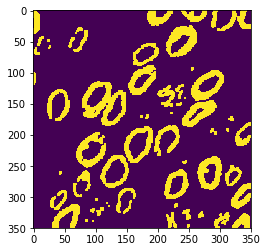

In [139]:
kernel = np.ones((4,4), np.uint8)
plt.imshow(binary_opening(binaryimg, structure=kernel))

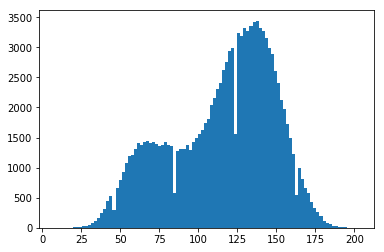

In [99]:
plt.hist(img.ravel(), bins=100);

In [127]:
def icm (segmentation,img,alpha):
    y,x=img.shape
    #mu=np.unique(segmentation)
    mu = [65, 140]
    diffDict=dict()
       
    for k in mu:
        diffNeighborCt=np.zeros((y,x))
        for i,h in [(0,1),(1,0),(-1,0),(0,-1)]:
            tmp = img[1+i:y-1+i,1+h:x-1+h]!=k
            diffNeighborCt[1:y-1,1:x-1] += tmp
            
        diffDict[k]=diffNeighborCt * 4
    vVals=np.zeros((y,x))
    for i in range(y):
        for j in range(x):
            temp=[]
            for k in mu:
                temp.append(alpha*(k-img[i,j])**2+diffDict[k][i,j])
            #temp.append(alpha*(segmentation[i,j]-img[i,j])**2+diffNeighborCt[i,j])
            vVals[i][j]=mu[temp.index(min(temp))]
    return vVals 

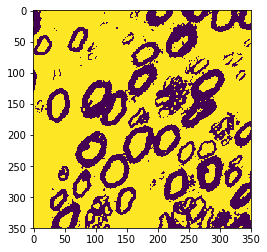

In [115]:
imthresh = img<85

var = icm(imthresh, img, 0.0005)

plt.imshow(var);

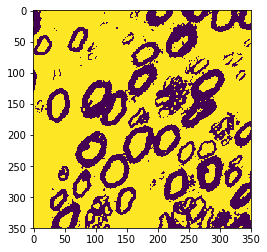

In [128]:
imthresh = img<70
alpha = 0.5

var = icm(imthresh, img, alpha)

for i in range(10):
    var = icm(imthresh, var, alpha)

plt.imshow(var);

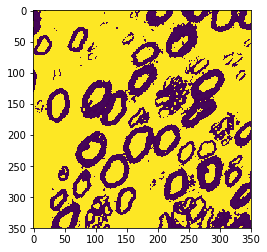

In [126]:
plt.imshow(var + imthresh)

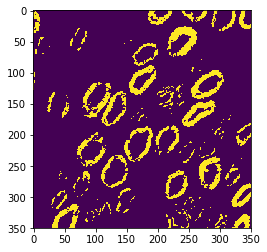

In [125]:
plt.imshow(imthresh)